In [32]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms

from utils import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
real_data_path = "../data/data.npy"
real_data = np.load(real_data_path)

ai_data_path = "../data/data_ai.npy"
ai_data = np.load(ai_data_path)

combined_data = np.concatenate([real_data, ai_data], axis = 0)

# we apply stratified sampling
X_train, X_test, y_train, y_test = train_test_split(combined_data[:,:-1], combined_data[:,-1], test_size=0.2, stratify=combined_data[:,-1])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(ai_data[:,:-1], ai_data[:,-1], test_size=0.2, stratify=ai_data[:,-1])

In [55]:
train_data = DataLoader([X_train, y_train], shuffle=True, batch_size=8, shape=[128,128], device=DEVICE)
test_data = DataLoader([X_test, y_test], shape=[128,128], device=DEVICE)

real_data = DataLoader("../data/data.npy", shape=[128,128], device=DEVICE)
ai_data = DataLoader("../data/data_ai.npy", shape=[128,128], device=DEVICE)

In [56]:
train_data, test_data

(Data with shape of (64, 1, 128, 128), shuffle = True, batch_size = 8,
 Data with shape of (16, 1, 128, 128), shuffle = False, batch_size = 1)

In [ ]:
# import pandas as pd

# huge_data = pd.read_csv("../data/fer2013.csv")

# huge_data = huge_data[huge_data.emotion.isin([0, 3, 4, 5])].drop(["Usage"], axis = 1)
# map_labels = {0:0, 3:1, 4:2, 5:3}
# huge_data.emotion = huge_data.emotion.map(map_labels)

# num_rows_to_drop = int(0.75 * len(huge_data))
# rows_to_drop = np.random.choice(huge_data.index, num_rows_to_drop, replace=False)
# huge_data = huge_data.drop(index=rows_to_drop)


# huge_data.pixels = huge_data.pixels.apply(lambda x: np.array(x.split(" ")))



# huge_data.info()

In [ ]:
# huge = np.concatenate([np.stack(huge_data.to_numpy()[:,1]).astype("float") / 255, huge_data.to_numpy()[:,0].reshape(-1,1)], axis = 1).astype("float")


# X_train, X_test, y_train, y_test = train_test_split(huge[:,:-1], huge[:,-1], test_size=0.2, stratify=huge[:,-1])

# train_data = DataLoader([X_train, y_train], shuffle=True, batch_size=64, shape=[48,48], device=DEVICE)
# test_data = DataLoader([X_test, y_test], shape=[48,48], device=DEVICE)


In [57]:
# we had to keep it in different file so we can use it in live test folder 
from model import *
    
model = CNN128()
sum(p.numel() for p in model.parameters())

1052372

In [58]:
N, C, W, H = train_data.shape
N_test = test_data.size

n_epoch = 100

model = CNN128()
optimizer = optim.Adam(model.parameters(), lr = 5e-3)
criterion = nn.CrossEntropyLoss(reduction="sum")

model.to(DEVICE)

losses = {"train": list(), "test": list()}

best_test_loss = float('inf')

for epoch in range(n_epoch):
    data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        
        transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05))], p=0.5),
        
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.3),
        
        transforms.ToTensor(),
    ])

    train_data = DataLoader(data=[X_train, y_train], shuffle=True, batch_size=8, shape=[128,128], device=DEVICE, transform=data_transforms)
    model.train()
    
    running_loss = .0
    for X_batch, y_batch in train_data:

        y_pred = model(X_batch.float())

        loss = criterion(y_pred, y_batch.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
    
    running_loss /= N


    # test the model
    model.eval()
    predictions = model(test_data.X.float())
    pred_class = torch.argmax(predictions, axis = 1)
    test_acc = (pred_class == test_data.y).float().mean()
    test_loss = criterion(predictions, test_data.y.long()).item() / N_test
    
    print(f"Epoch: {epoch+1:>2}, Train loss: \033[92m{running_loss:.4f}\033[0m, Test loss: \033[94m{test_loss:.4f}\033[0m, Test accuracy: {colorize_accuracy(test_acc)}{test_acc:.4f}\033[0m.")

    # save the best model
    if test_loss < best_test_loss:
        best_test_loss == test_loss
        best_model = model.state_dict()

    losses["train"].append(running_loss)
    losses["test"].append(test_loss)


# load the best model
model.load_state_dict(best_model)


Epoch:  1, Train loss: 1.3223, Test loss: 3.0160, Test accuracy: 0.2500.
Epoch:  2, Train loss: 0.8786, Test loss: 1.9846, Test accuracy: 0.2500.
Epoch:  3, Train loss: 0.1235, Test loss: 1.2755, Test accuracy: 0.2500.
Epoch:  4, Train loss: 0.1943, Test loss: 1.3011, Test accuracy: 0.2500.
Epoch:  5, Train loss: 0.1553, Test loss: 1.3282, Test accuracy: 0.2500.
Epoch:  6, Train loss: 0.1601, Test loss: 1.3748, Test accuracy: 0.2500.
Epoch:  7, Train loss: 0.1518, Test loss: 1.3508, Test accuracy: 0.2500.
Epoch:  8, Train loss: 0.1518, Test loss: 1.3312, Test accuracy: 0.3125.
Epoch:  9, Train loss: 0.1729, Test loss: 1.3363, Test accuracy: 0.3125.
Epoch: 10, Train loss: 0.1528, Test loss: 1.3299, Test accuracy: 0.2500.
Epoch: 11, Train loss: 0.1451, Test loss: 1.3277, Test accuracy: 0.2500.
Epoch: 12, Train loss: 0.1156, Test loss: 1.3157, Test accuracy: 0.2500.
Epoch: 13, Train loss: 0.1859, Test loss: 1.3719, Test accuracy: 0.2500.
Epoch: 14, Train loss: 0.1514, Test loss: 1.3354, T

<All keys matched successfully>

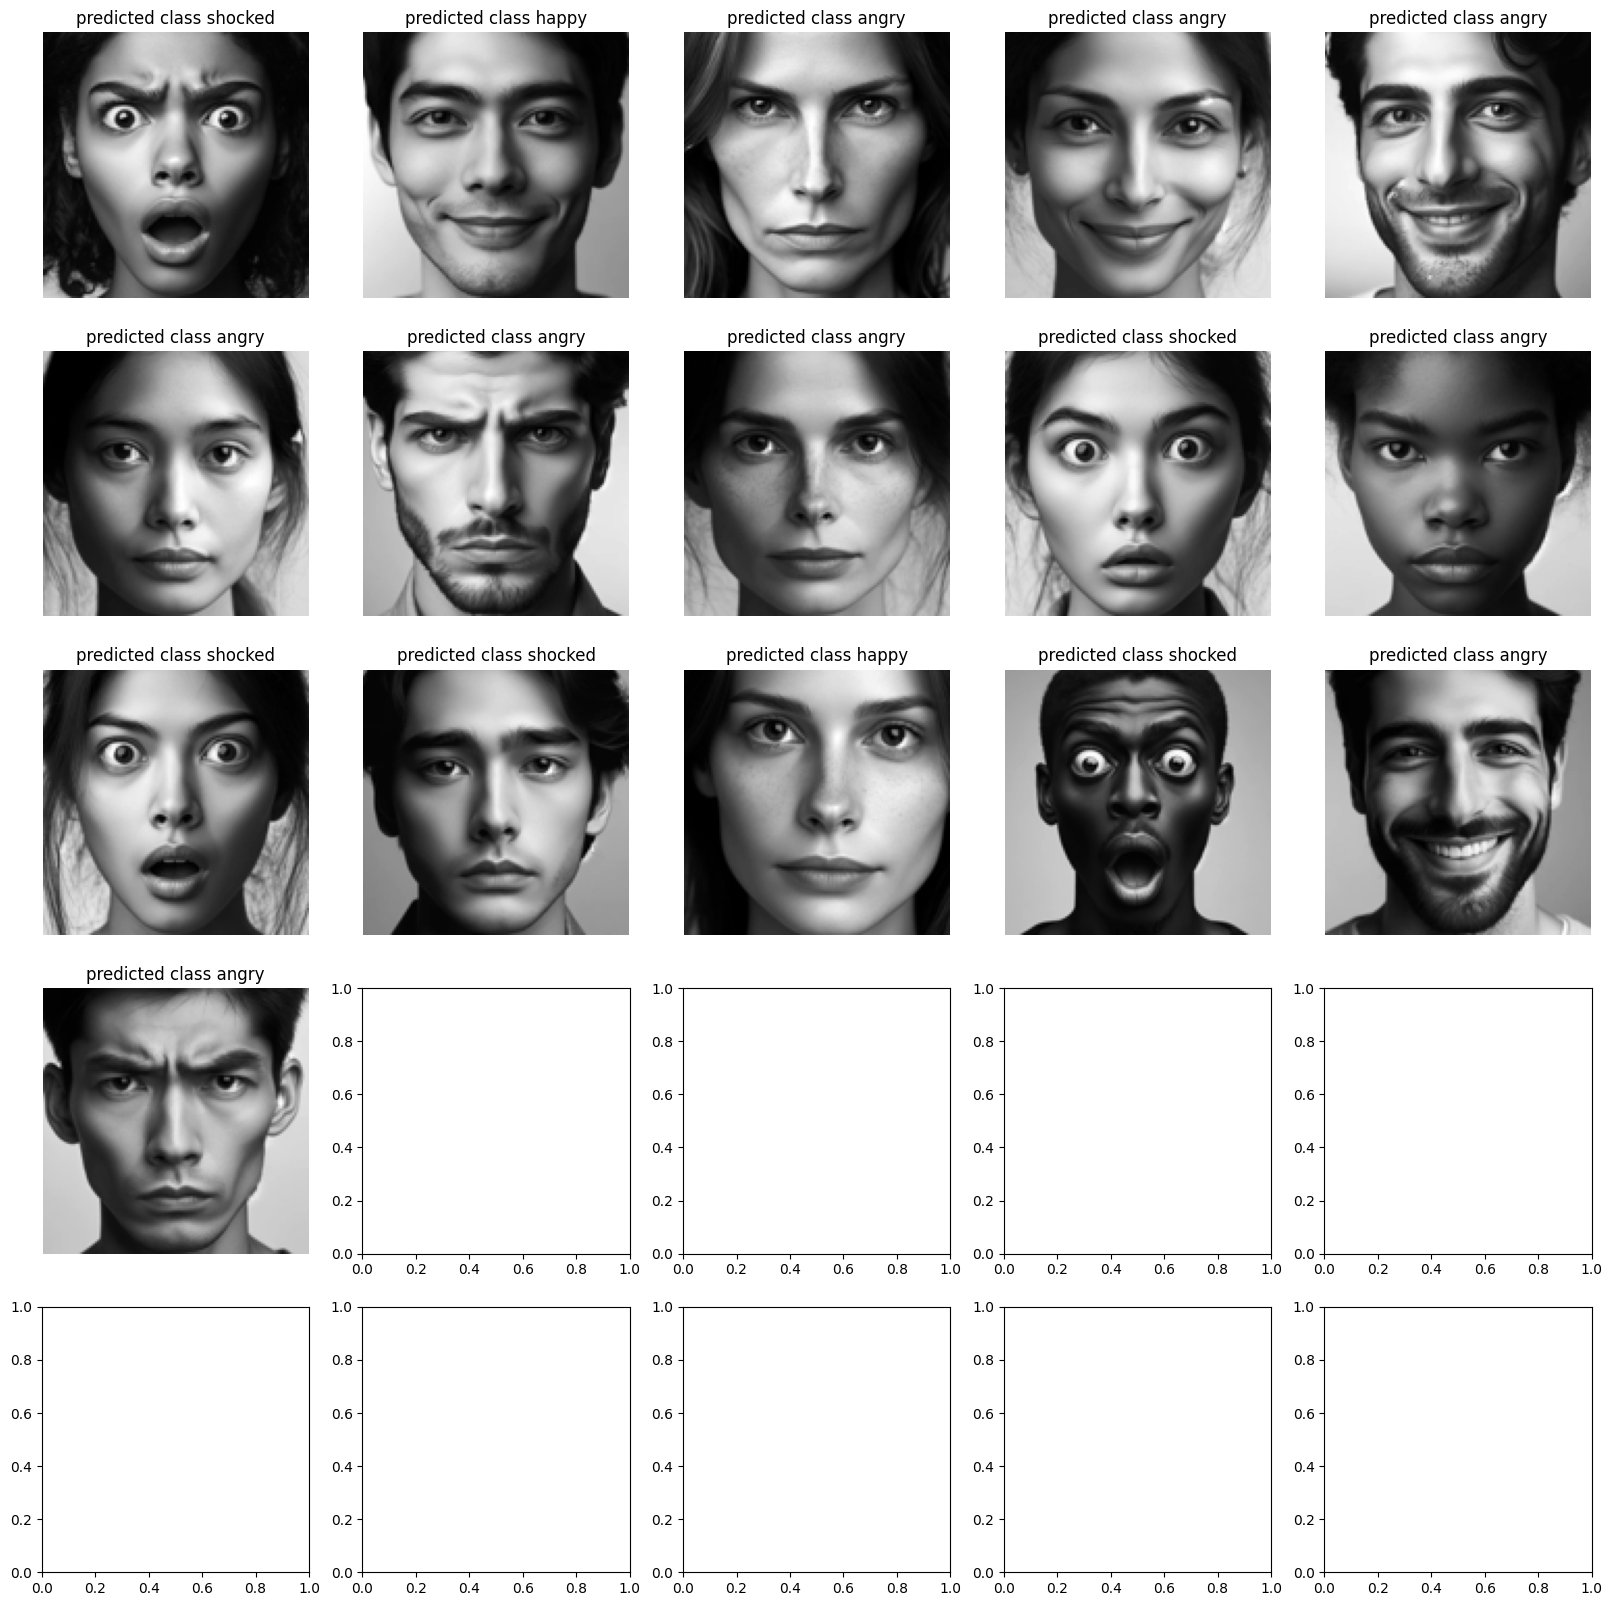

In [61]:
emotion_map = {0.:"angry", 1.:"happy", 2.:"sad", 3.:"shocked"}

predictions = model(test_data.X.float()).argmax(axis = 1)


fig, axs = plt.subplots(5, 5, figsize=(20, 20))

axs = axs.flatten()
# Loop through each image and plot it
for i in range(test_data.size):
    if i == 25:
        break
    axs[i].imshow(test_data.X[i].cpu().squeeze(), cmap='gray')  # Assuming grayscale images
    axs[i].axis('off')  # Turn off axis labels
    axs[i].set_title(f"predicted class {emotion_map[int(predictions[i])]}")  # Add a title for each subplot

plt.show()

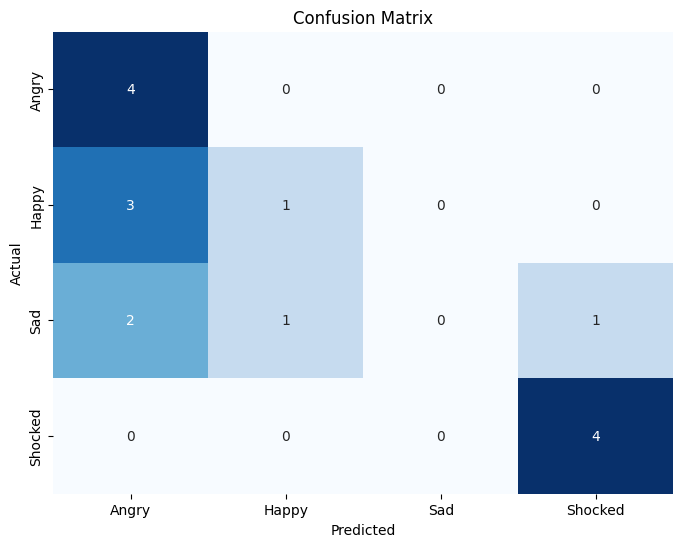

Loss: 1.1330, Accuracy = 0.5625


In [62]:
test_model(model, test_data, criterion)

In [59]:
# Assuming 'train_data' is your DataLoader instance
all_X = []
all_y = []

# Loop through the DataLoader and collect data
for X_batch, y_batch in train_data:
    all_X.append(X_batch.numpy())  # Convert tensors to numpy arrays
    all_y.append(y_batch.numpy())

# Concatenate all data and labels
all_X = np.concatenate(all_X, axis=0)
all_y = np.concatenate(all_y, axis=0)

# Optionally, you can combine data and labels if needed
combined_data = np.concatenate((all_X.reshape(all_X.shape[0], -1), all_y.reshape(-1, 1)), axis=1)

# Save the combined data as a .npy file
np.save("../data/train_data.npy", combined_data)

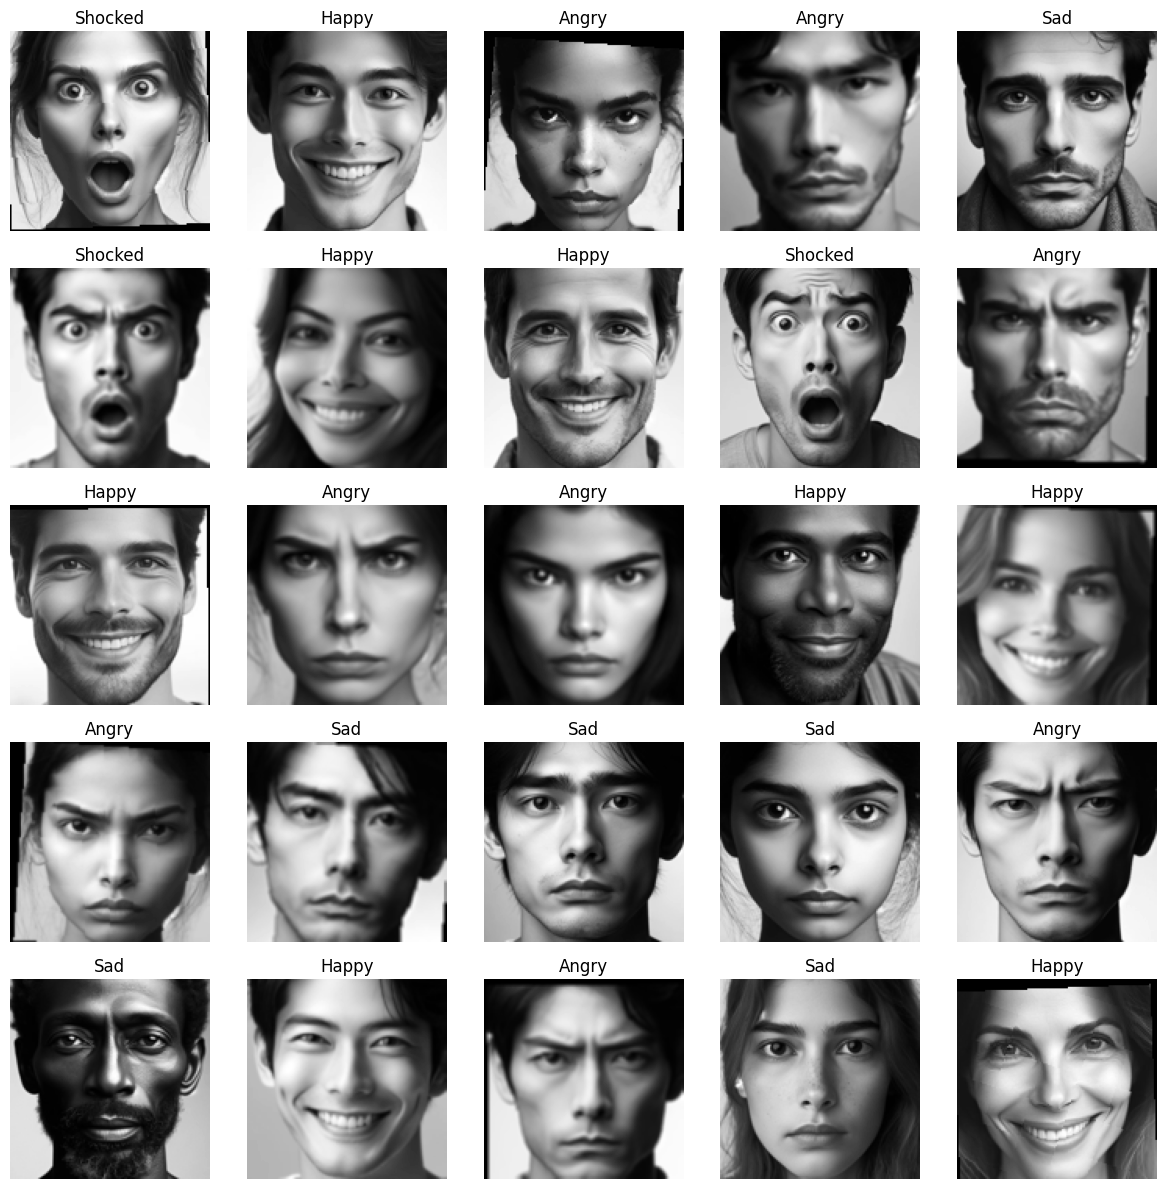

In [60]:
from visualize_data import visualize

visualize("../data/train_data.npy", 5, 128, 1)

In [ ]:
train_data.y.unique(return_counts=True), test_data.y.unique(return_counts=True)

In [ ]:
import pandas as pd

df = pd.read_csv("../data/fer2013.csv")

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')))
img_array = np.stack(img_array, axis=0)
img_array.shape



## Save the best model

In [ ]:
torch.save(model.state_dict(), "../model/model_1")